## Grid Search

Now that we know how to evaluate how well a model generalizes, we can take the next step and improve the model’s generalization performance by tuning its parameters. We discussed the parameter settings of many of the algorithms in scikit-learn in Chapters 2 and 3, and it is important to understand what the parameters mean before trying to adjust them. Finding the values of the important parameters of a model (the ones that provide the best generalization performance) is a tricky task, but necessary for almost all models and datasets. 

Because it is such a common task, there are standard methods in scikit-learn to help you with it. The most commonly used method is grid search, which basically means trying all possible combinations of the parameters of interest.

Consider the case of a kernel SVM with an RBF (radial basis function) kernel, as implemented in the *SVC* class. As we discussed in Chapter 2, there are two important parameters: the kernel bandwidth, *gamma*, and the regularization parameter, *C*. 

Say we want to try the values 0.001, 0.01, 0.1, 1, 10, and 100 for the parameter C, and the same for gamma. Because we have six different settings for C and gamma that we want to try, we have 36 combinations of parameters in total. Looking at all possible combinations creates a table (or grid) of parameter settings for the SVM, as shown here:

%%HTML

<table>
    <tr>
      <th>&nbsp;</th>
      <th>C = 0.001</th>
      <th>C = 0.01</th>
      <th>…</th>
      <th>C = 10</th>
    </tr>
    <tr>
      <td>gamma=0.001</td>
	  <td>SVC(C=0.001, gamma=0.001)</td>
	  <td>SVC(C=0.01, gamma=0.001)</td>
      <td>…</td>
	  <td>SVC(C=10, gamma=0.001)</td>
    </tr>
    <tr>
      <td>gamma=0.01</td>
      <td>SVC(C=0.001, gamma=0.01)</td>
      <td>SVC(C=0.01, gamma=0.01)</td>
      <td>…</td>
      <td>SVC(C=10, gamma=0.01)</td>
    </tr>
    <tr>
      <td>…</td>
      <td>…</td>
      <td>…</td>
      <td>…</td>
      <td>…</td>
    </tr>
    <tr>
      <td>gamma=100</td>
      <td>SVC(C=0.001, gamma=100)</td>
      <td>SVC(C=0.01, gamma=100)</td>
      <td>…</td>
      <td>SVC(C=10, gamma=100)</td>
  </tr>

We can implement a simple grid search just as for loops over the two parameters, training and evaluating a classifier for each combination:

In [2]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn
from IPython.display import display
import mglearn

# Don't display deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
iris = load_iris()

In [4]:
# Naive grid search implementation
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print("Size of training set: {}   size of test set: {}".format(X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # For each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # Evaluate the SVC on the test set
        score = svm.score(X_test, y_test)
        # If we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Size of training set: 112   size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


### The Danger of Overfitting the Parameters and the Validation Set

Given this result, we might be tempted to report that we found a model that performs with 97% accuracy on our dataset. However, this claim could be overly optimistic (or just wrong), for the following reason: we tried many different parameters and selected the one with best accuracy on the test set, but this accuracy won’t necessarily carry over to new data. 

Because we used the test data to adjust the parameters, we can no longer use it to assess how good the model is. This is the same reason we needed to split the data into training and test sets in the first place; we need an independent dataset to evaluate, one that was not used to create the model.

One way to resolve this problem is to split the data again, so we have three sets: the training set to build the model, the validation (or development) set to select the parameters of the model, and the test set to evaluate the performance of the selected parameters. 

This figure shows what this looks like:

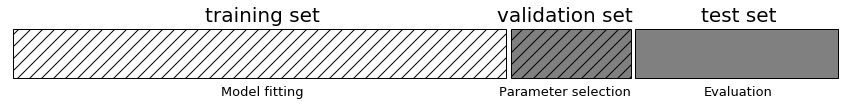

In [5]:
mglearn.plots.plot_threefold_split()

After selecting the best parameters using the validation set, we can rebuild a model using the parameter settings we found, but now training on both the training data and the validation data. This way, we can use as much data as possible to build our model. This leads to the following implementation:

In [6]:
# Split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)

# Split train+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)

print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # For each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # Evaluate the SVC on the validation set
        score = svm.score(X_valid, y_valid)
        # If we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# Rebuild a model on the combined training and validation set,
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)

print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84   size of validation set: 28   size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


The best score on the validation set is 96%: slightly lower than before, probably because we used less data to train the model (X_train is smaller now because we split our dataset twice). However, the score on the test set—the score that actually tells us how well we generalize—is even lower, at 92%. So we can only claim to classify new data 92% correctly, not 97% correctly as we thought before!

The distinction between the training set, validation set, and test set is fundamentally important to applying machine learning methods in practice. Any choices made based on the test set accuracy “leak” information from the test set into the model. Therefore, it is important to keep a separate test set, which is only used for the final evaluation. 

It is good practice to do all exploratory analysis and model selection using the combination of a training and a validation set, and reserve the test set for a final evaluation—this is even true for exploratory visualization. Strictly speaking, evaluating more than one model on the test set and choosing the better of the two will result in an overly optimistic estimate of how accurate the model is.

### Grid Search with Cross-Validation

While the method of splitting the data into a training, a validation, and a test set that we just saw is workable, and relatively commonly used, it is quite sensitive to how exactly the data is split. From the output of the previous code snippet we can see that grid search selects 'C': 10, 'gamma': 0.001 as the best parameters, while the output of the code in the previous section selects 'C': 100, 'gamma': 0.001 as the best parameters. 

For a better estimate of the generalization performance, instead of using a single split into a training and a validation set, we can use cross-validation to evaluate the performance of each parameter combination. This method can be coded up as follows:

In [8]:
from sklearn.model_selection import cross_val_score

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # For each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        # Perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # Compute mean cross-validation accuracy
        score = np.mean(scores)
        # If we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
# Rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

To evaluate the accuracy of the SVM using a particular setting of C and gamma using five-fold cross-validation, we need to train 36 * 5 = 180 models. As you can imagine, the main downside of the use of cross-validation is the time it takes to train all these models.

The following visualization illustrates how the best parameter setting is selected in the preceding code:

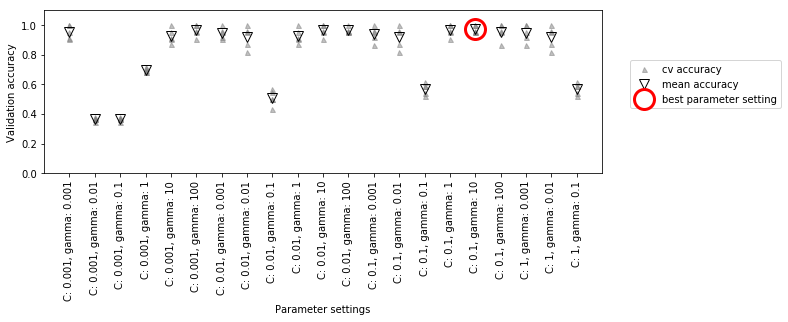

In [9]:
mglearn.plots.plot_cross_val_selection()

For each parameter setting (only a subset is shown), five accuracy values are computed, one for each split in the cross-validation. Then the mean validation accuracy is computed for each parameter setting. The parameters with the highest mean validation accuracy are chosen, marked by the circle.

#### Note

As we said earlier, cross-validation is a way to evaluate a given algorithm on a specific dataset. However, it is often used in conjunction with parameter search methods like grid search. For this reason, many people use the term *cross-validation* colloquially to refer to grid search with cross-validation.

The overall process of splitting the data, running the grid search, and evaluating the final parameters is illustrated here:

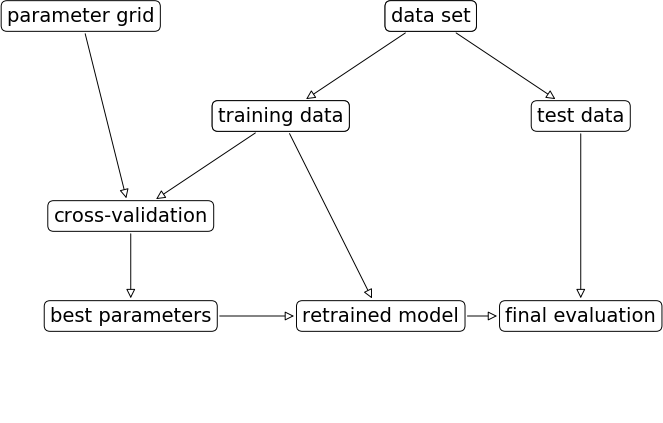

In [10]:
mglearn.plots.plot_grid_search_overview()